# Packages
First we install some required packages.

In [15]:
!pip install tpot
!pip install whois

     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 163kB 20.4MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=ef2349ae9a7fea252e4015682b60d3d56dddfe4073b041b6a4cb278027c1de1e
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Created wheel for whois: filename=whois-0.9.7-cp36-none-any.whl size=8889 sha256=2793840bc76a704c11af63c028e45d33194e37dde1b568ff4af1b94c00c9aece
  Stored in directory: /root/.cache/pip/wheels/56/4c/53/02bc75ef02bd738b5ee9ece5bd61f86ba25c543aebca583cd2
Successfully built whois


# Data Feature Extraction

We have downloaded a list of benign URLs in benign_list.csv and malignant URLs in malignant_list.csv.

We run the following script to extract various features from these URLs using REGEX and python whois library.

The first cell contains the function for extracting URLs and the rest cells call this for benignant and malicious URLs.

*NOTE: This script takes a lot of time, and is provided here only for reference. We have run the script on a high configuration GCP instance for two hours.
We directly provide the generated 'Benign.csv' and 'malignant.csv'*

In [ ]:

import re
import requests
import http.client
import urllib
import whois
import datetime


Suspicious_Words=['secure','account','update','banking','login','click','confirm','password','verify','signin','ebayisapi','lucky','bonus']

Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']

def Total_Dots(link):
	dot='.'
	count=0
	for i in link:
		if i==dot:
			count+=1
	return count

def Total_Delims(str):
	delim=['-','_','?','=','&']
	count=0
	for i in str:
		for j in delim:
			if i==j:
				count+=1
	return count
	

def no_of_hyphens_in_domain(link):
	hyph='-'
	count=0
	for i in link:
		if i==hyph:
			count+=1
	return count

def ip_presence(lis): # Function to Check for Presence of Ip in Domain
	for i in lis:
		if i.isdigit()==False:
			return 0
	else:
		return 1

def Construct_Vector(mystr):
	"""
	Actual Execution function which to do Processing on URLs
	"""
	### Defined Vector which will contain the Values for Different Parameters associated with a URL
	vec=[]	

	removed_protocol=re.sub(r'^http(s*)://','',mystr)		###Removed Protocol in a given URL using Python Regex

	vec.append(len(removed_protocol))	 					#append length of URL to the Vector
	vec.append(Total_Dots(removed_protocol)) 	  			#append Number of Dots in URL to the Vector

	### Checking for Presence of Suspicious Words in URL
	for i in Suspicious_Words:
		if re.search(i,removed_protocol,re.IGNORECASE):
			vec.append(1)								#security sensitive word present so append 1
			break
	else:
		vec.append(0)									#security sensitive word not present so append 0


	patt=r'^[^/]*'										#pattern to extract domain from the URL
	patt_path=r'/[^/]*'									#pattern to extract path of URL
	dom=re.match(patt,removed_protocol).group(0)
	info=re.findall(patt_path,removed_protocol)
	###print('Domain Name: ',dom)
	doma_hyph_count=no_of_hyphens_in_domain(dom)
	vec.append(int(doma_hyph_count))					#Appending Number of hyphens in Domain of URL to the Vector
	domain_Tokens=(dom).split('.')
	domain_Tokens=[x for x in domain_Tokens if x!='']	##Removing Null Values (if Any)
	##print('Domain Length: ',len(dom))
	path_tokens=[re.sub('/','',x) for x in info]
	if path_tokens!=[]:
		file_n_args=path_tokens[-1]
	else:
		file_n_args=''
	path_tokens=path_tokens[:-1]
	info=[x for x in info if x!='']
	slashes=len(info)
	#print('Slashes:',slashes)
	dir_len=0
	for i in (path_tokens):
		dir_len+=len(i)
	dir_len+=slashes
	vec.append(int(dir_len))								#Appeding Directory length to the URL to the Vector
	#print('Directory Length: ',dir_len)
	num_subdir=len(path_tokens)
	#print('Number of Subdirectories :',num_subdir)
	vec.append(num_subdir)									#Appending Number of Subdirectories	Present in the URL to the Vector
	#print('Path Tokens : ',path_tokens)
	TLD=domain_Tokens[-1]	
	#print('Top Level Domain :',TLD)
	vec.append(len(dom)) 									#Domain Length
	vec.append(len(domain_Tokens))					#Domain Token Count
	vec.append(len(path_tokens)) 					#Path Token Count
	#asn_num=msh.check(dom)
	is_ip=ip_presence(domain_Tokens)
	vec.append(is_ip) 								#Presence of ip address Yes:1, No:0
	##print('ASN number :',asn_num)
	domain_tok_lengts=[]
	for i in domain_Tokens:
		domain_tok_lengts.append(len(i))
	largest_dom_token_len=max(domain_tok_lengts)
	vec.append(largest_dom_token_len)  				#Largest Domain Token Length

	avg_dom_Tok_len=float(sum(domain_tok_lengts))/len(domain_tok_lengts)

	vec.append(avg_dom_Tok_len)     				#Average Domain Token Length

	path_tok_lengts=[]
	path_tok_dots=0
	path_tok_delims=0
	avg_path_Tok_len=0
	largest_path_token_len=0
	if len(path_tokens):
		for i in path_tokens:
			path_tok_lengts.append(len(i))
			path_tok_dots=Total_Dots(i)
			path_tok_delims=Total_Delims(i)
		avg_path_Tok_len=float(sum(path_tok_lengts))/len(path_tok_lengts)
		largest_path_token_len=max(path_tok_lengts)
		vec.append(largest_path_token_len) 				#Largest Path Token Length
		vec.append(avg_path_Tok_len)					#Average Path Token Length
	else:
		vec.append(largest_path_token_len)				#Largest Path Token Length :0 (No, Path Tokens)
		vec.append(avg_path_Tok_len)					#Average Path Token Length :0 (No, Path Tokens)	
	#print('Largest Path Token Length:',largest_path_token_len)
	#print('Path Token Total Dots:',path_tok_dots)
	#print('Path Token Delims:',path_tok_delims)
	if is_ip:
		vec.append(0)									#Ip address present so no suspicious TLD
	else:
		for i in Suspicious_TLD:
			if re.search(i,TLD,re.IGNORECASE):
				vec.append(1)							#Suspicious TLD
				break
		else:
			vec.append(0)								#Non Suspicious TLD
	if file_n_args!='':		

		### Define Condition whether file and arguments present in the URL
		tmp=file_n_args.split('?')
		file=tmp[0]
		if len(tmp)>1:
			args=tmp[1]
		else:
			args=''
		#print('File:',file)
		#print('Arguments:',args)
		vec.append(len(file))							#Length of file
		vec.append(Total_Dots(file))					#Total_Dots in file name
		vec.append(Total_Delims(file))					#Total_Delims in file name
		#print('Total dots in file: ',Total_Dots(file))
		#print('Total Delims in file: ',Total_Delims(file))

		if args=='':
			### Checking if any POST arguments present in the URL or not
			vec.append(0)									#Length of Argument Appended to the Vector
			vec.append(0)									#Number of Variables Appended to the Vector
			vec.append(0)									#Length of larges variable value Appended to the Vector
			vec.append(0)									#Maximum number of Delims Appended to the Vector
			#print('argument length:',0)
			#print('number of arguments:',0)
			#print('length of Largest variable value:',0)
			#print('Maximun no of delims:',0)

		else:
			## indicated Presence of POST arguments in the URL

			vec.append(len(args)+1)							#Length of Argument Appended to the Vector
			#print('argument length:',len(args)+1)
			arb=args.split('&')
			vec.append(len(arb))							#Number of Arguments Appended to the Vector
			#print('Number of arguments',len(arb))
			len_var=[]
			max_delim=[]
			for i in arb:
				### Spliting POST Arguments around '=' sign
				tmp=i.split('=')
				if len(tmp)>1:
					len_var.append(len(tmp[1]))
					max_delim.append(Total_Delims(tmp[0]))
					max_delim.append(Total_Delims(tmp[1]))
				else:
					len_var.append(0)
					max_delim.append(0)
			vec.append(max(len_var))						#Length of Largest variable value
			#print('length of Largest variable value:',max(len_var))
			max_delim=max(max_delim)
			vec.append(max_delim)							#Maximum number of Delimeters	
			#print('Maximum no of delims:',max_delim)


	else:

		
		vec.append(0)									#Length of file Appended to the Vector
		vec.append(0)									#Total_Dots in file name Appended to the Vector
		vec.append(0)									#Total_Delims in file name Appended to the Vector
		vec.append(0)									#Length of Argument Appended to the Vector
		vec.append(0)									#Number of Variables Appended to the Vector
		vec.append(0)									#Length of larges variable value Appended to the Vector
		vec.append(0)									#Maximum number of Delims Appended to the Vector
		#print('argument length:',0)
		#print('number of arguments:',0)
	
	

	### Defined Avg Month of the Year
	avg_month_time=365.2425/12.0

	###Loop to remove extra delimeter and Dots in the URL to query WHOIS server
	while(True):
		if(not dom[-1].isalnum()):
			dom=dom[:-1]
		else:
			break

	### Sending Request to WHOIS Server
	try:
		who_info=whois.whois(dom)
	except Exception:
		vec.append(-1)									### created age in months
		vec.append(-1)									### expiry age in months
		vec.append(-1)									### updated age in days
		vec.append(-1)									### zip code
		return vec

	### Define case where there may be an exception/error in query or maybe record not present in the WHOIS database
	if(who_info.creation_date == None and who_info.expiration_date == None and who_info.updated_date == None and who_info.zipcode == None):
		vec.append(-1)									### created age in months Appended to the Vector
		vec.append(-1)									### expiry age in months Appended to the Vector
		vec.append(-1)									### updated age in days Appended to the Vector
		vec.append(-1)									### zip code Appended to the Vector
		return vec

	### Further Processing to Creation Date, Updation Date, Expiry Date etc of a URL
	### Processing involves checking whether the datetime object returned is a list or string and then extract information from it
	if(who_info.creation_date==None or type(who_info.creation_date) is str):
		vec.append(-1)
	else:
		if(type(who_info.creation_date) is list): 
			create_date=who_info.creation_date[-1]
		else:
			create_date=who_info.creation_date
		if(type(create_date) is datetime.datetime):
			today_date=datetime.datetime.now()
			create_age_in_mon=((today_date - create_date).days)/avg_month_time
			create_age_in_mon=round(create_age_in_mon)
			vec.append(create_age_in_mon)					#### appending created age in months Appended to the Vector
		else:
			vec.append(-1)									#### created age error so append -1

	if(who_info.expiration_date==None or type(who_info.expiration_date) is str):
		vec.append(-1)
	else:
		if(type(who_info.expiration_date) is list):
			expiry_date=who_info.expiration_date[-1]
		else:
			expiry_date=who_info.expiration_date
		if(type(expiry_date) is datetime.datetime):
			today_date=datetime.datetime.now()
			expiry_age_in_mon=((expiry_date - today_date).days)/avg_month_time
			expiry_age_in_mon=round(expiry_age_in_mon)
			vec.append(expiry_age_in_mon)					#### appending expiry age in months Appended to the Vector
		else:
			vec.append(-1)									#### expiry date error so append -1

	if(who_info.updated_date==None or type(who_info.updated_date) is str):
		vec.append(-1)		
	else:
		if(type(who_info.updated_date) is list):
			update_date=who_info.updated_date[-1]
		else:
			update_date=who_info.updated_date
		if(type(update_date) is datetime.datetime):
			today_date=datetime.datetime.now()
			update_age_in_days=((today_date - update_date).days)
			vec.append(update_age_in_days)					#### appending updated age in days Appended to the Vector
		else:
			vec.append(-1)


	zipcode=who_info.zipcode
	if(zipcode == None or (type(zipcode) is not str)):
		zipcode=-1
	else:
		if '-' in zipcode:
			zipcode=re.sub('-*','',zipcode)
		zipcode=re.sub(r'[A-Za-z\s]*','',zipcode)

	if(type(zipcode) is str and zipcode.isdigit()):
		vec.append(int(zipcode))							####appending zipcode of the Given URL to the Vector
	else:
		zipcode=-1
		vec.append(zipcode)
	return vec

In [ ]:
import numpy as np
import pandas as pd
import pickle
import time

df_object=pd.read_csv('benign_list.csv',header=0)

training_df=pd.DataFrame(columns=('len of url','no of dots','security sensitive words','no of hyphens in dom',\
'dir_len','no of subdir','domain len','domain token count','path token count','ip present','largest domain_tok_len',\
'avg_dom_token_len','largest path token length','avg path token length','suspicious tld','len_of_file','total dots in file',\
'total delims in file','len_of_argument','no_of_variables','len_of_largest_variable_val',\
'max_no_of_argum_delims','create_age(months)','expiry_age(months)','update_age(days)','zipcode'))

print('\n\n===========================================================')
print('Starting to Extract Training Data from URLs')
print('===========================================================\n\n')
print('And we go.....3,2,1')
time.sleep(3)

###Starting To Store information on Each URL
for i in range(len(df_object['url'])):
	vec=Construct_Vector(df_object.url[i])
	training_df.loc[i]=vec
	print('Training example :',i,"done")
#training_df['URL']=df_object['URL']
training_df['Label']=1
training_df['URL']=df_object.url
del(df_object)
	
print('all done feature values for training set obtained')


training_df.to_csv('Benign.csv')


In [ ]:
import numpy as np
import pandas as pd
import pickle
import time

df_object=pd.read_csv('malignant_list.csv',header=0)

training_df=pd.DataFrame(columns=('len of url','no of dots','security sensitive words','no of hyphens in dom',\
'dir_len','no of subdir','domain len','domain token count','path token count','ip present','largest domain_tok_len',\
'avg_dom_token_len','largest path token length','avg path token length','suspicious tld','len_of_file','total dots in file',\
'total delims in file','len_of_argument','no_of_variables','len_of_largest_variable_val',\
'max_no_of_argum_delims','create_age(months)','expiry_age(months)','update_age(days)','zipcode'))

print('\n\n===========================================================')
print('Starting to Extract Training Data from URLs')
print('===========================================================\n\n')
print('And we go.....3,2,1')
time.sleep(3)

###Starting To Store information on Each URL
for i in range(len(df_object['url'])):
	vec=Construct_Vector(df_object.url[i])
	training_df.loc[i]=vec
	print('Training example :',i,"done")
#training_df['URL']=df_object['URL']
training_df['Label']=1
training_df['URL']=df_object.url
del(df_object)
	
print('all done feature values for training set obtained')


training_df.to_csv('Malignant.csv')


# Reading the generated CSVs

We read the generated CSVs and remove some unnecessary features.



In [1]:
import pandas as pd
dataframe=pd.read_csv('malignant.csv')
dataframe.drop(['Unnamed: 0', 'URL', 'zipcode'], axis=1, inplace=True)
dataframe

,len of url,no of dots,security sensitive words,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,ip present,largest domain_tok_len,avg_dom_token_len,largest path token length,avg path token length,suspicious tld,len_of_file,total dots in file,total delims in file,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),Label
0,107.0,2.0,1.0,0.0,62.0,6.0,12.0,2.0,6.0,0.0,9.0,5.500000,18.0,9.166667,0.0,33.0,0.0,2.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
1,20.0,3.0,0.0,1.0,1.0,0.0,19.0,4.0,0.0,0.0,9.0,4.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
2,37.0,1.0,0.0,0.0,9.0,1.0,28.0,2.0,1.0,0.0,24.0,13.500000,7.0,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
3,92.0,2.0,0.0,0.0,70.0,8.0,22.0,3.0,8.0,0.0,14.0,6.666667,11.0,7.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
4,79.0,2.0,1.0,0.0,45.0,6.0,25.0,2.0,6.0,0.0,21.0,12.000000,11.0,6.333333,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8882,28.0,2.0,0.0,0.0,1.0,0.0,27.0,3.0,0.0,0.0,14.0,8.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
8883,37.0,3.0,0.0,0.0,1.0,0.0,36.0,4.0,0.0,0.0,19.0,8.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
8884,88.0,3.0,0.0,0.0,9.0,2.0,43.0,3.0,2.0,0.0,30.0,13.666667,4.0,3.000000,0.0,36.0,1.0,4.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
8885,54.0,3.0,0.0,0.0,1.0,0.0,30.0,3.0,0.0,0.0,17.0,9.333333,0.0,0.000000,0.0,23.0,1.0,3.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1


In [ ]:
# import pandas as pd
# bdataframe=pd.read_csv('benign.csv')
# bdataframe.drop(['Unnamed: 0', 'URL', 'zipcode'], axis=1, inplace=True)
# bdataframe['Label']=0

In [ ]:
# oridataframe=pd.read_csv('Malignant.csv')
# oridataframe.drop(['Unnamed: 0', 'URL', 'zipcode'], axis=1, inplace=True)
# #oridataframe

In [2]:
import numpy as np
import pandas as pd
dataframe2=pd.read_csv('Benign.csv')
dataframe2.drop(['Unnamed: 0', 'URL', 'zipcode'], axis=1, inplace=True)
#dataframe2
#combined

# Further Preprocessing...

We combine both benign and malignant CSV files, and generate a new finalcombined.csv with randomised records.

In [3]:
# Missing Data

combined=pd.concat([dataframe,dataframe2], ignore_index=True)

combined=combined.replace(-1,np.nan)
combined.fillna(combined.mean(), inplace=True)

(combined.sample(frac=1)).to_csv('finalcombined.csv', index=False)

In [4]:
import pandas as pd
ds=pd.read_csv('finalcombined.csv')
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
len of url,12381.0,63.608190,77.275465,7.0,23.000000,36.000000,72.000000,1379.0
no of dots,12381.0,2.367337,1.270370,1.0,2.000000,2.000000,3.000000,22.0
security sensitive words,12381.0,0.171069,0.376584,0.0,0.000000,0.000000,0.000000,1.0
no of hyphens in dom,12381.0,0.229384,0.613693,0.0,0.000000,0.000000,0.000000,14.0
dir_len,12381.0,18.362168,29.310942,0.0,1.000000,6.000000,26.000000,600.0
no of subdir,12381.0,1.577579,2.114202,0.0,0.000000,1.000000,3.000000,23.0
domain len,12381.0,20.411598,9.064633,4.0,15.000000,19.000000,24.000000,179.0
domain token count,12381.0,2.865116,0.769824,1.0,2.000000,3.000000,3.000000,14.0
path token count,12381.0,1.577579,2.114202,0.0,0.000000,1.000000,3.000000,23.0
ip present,12381.0,0.008319,0.090833,0.0,0.000000,0.000000,0.000000,1.0


# X-Y Split

We split the combined CSV file into X and Y..

In [5]:
# X and Y Split

Y=combined['Label']
X=combined.drop('Label', axis=1)

# One Hot Encoding

We one-hot encode the categorical data.

In [6]:
# One-hot encoding of categorical data

catcol=['security sensitive words','ip present', 'suspicious tld' ]
X=pd.get_dummies(X, columns=catcol)
X

,len of url,no of dots,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,largest domain_tok_len,avg_dom_token_len,largest path token length,avg path token length,len_of_file,total dots in file,total delims in file,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),security sensitive words_0.0,security sensitive words_1.0,ip present_0.0,ip present_1.0,suspicious tld_0.0,suspicious tld_1.0
0,107.0,2.0,0.0,62.0,6.0,12.0,2.0,6.0,9.0,5.500000,18.0,9.166667,33.0,0.0,2.0,0.0,0.0,0.0,0.0,232.919757,20.071597,933.958165,0,1,1,0,1,0
1,20.0,3.0,1.0,1.0,0.0,19.0,4.0,0.0,9.0,4.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.919757,20.071597,933.958165,1,0,1,0,1,0
2,37.0,1.0,0.0,9.0,1.0,28.0,2.0,1.0,24.0,13.500000,7.0,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.919757,20.071597,933.958165,1,0,1,0,1,0
3,92.0,2.0,0.0,70.0,8.0,22.0,3.0,8.0,14.0,6.666667,11.0,7.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.919757,20.071597,933.958165,1,0,1,0,1,0
4,79.0,2.0,0.0,45.0,6.0,25.0,2.0,6.0,21.0,12.000000,11.0,6.333333,9.0,1.0,0.0,0.0,0.0,0.0,0.0,232.919757,20.071597,933.958165,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12376,24.0,2.0,0.0,1.0,0.0,23.0,3.0,0.0,9.0,7.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.000000,7.000000,249.000000,1,0,1,0,1,0
12377,20.0,2.0,0.0,1.0,0.0,19.0,3.0,0.0,11.0,5.666667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,236.000000,4.000000,1017.000000,1,0,1,0,1,0
12378,12.0,2.0,0.0,1.0,0.0,11.0,3.0,0.0,3.0,3.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.000000,43.000000,578.000000,1,0,1,0,1,0
12379,23.0,2.0,0.0,1.0,0.0,22.0,3.0,0.0,14.0,6.666667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.000000,12.000000,1480.000000,1,0,1,0,1,0


# Scaling of numeric features

We scale the numeric features

In [7]:
# Scaling of numerical features

from sklearn.preprocessing import MinMaxScaler
cols_to_norm = ['len of url', 'no of dots', 'no of hyphens in dom', 'dir_len',
       'no of subdir', 'domain len', 'domain token count', 'path token count',
       'largest domain_tok_len', 'avg_dom_token_len',
       'largest path token length', 'avg path token length', 'len_of_file',
       'total dots in file', 'total delims in file', 'len_of_argument',
       'no_of_variables', 'len_of_largest_variable_val',
       'max_no_of_argum_delims', 'create_age(months)', 'expiry_age(months)',
       'update_age(days)']

X[cols_to_norm] = MinMaxScaler().fit_transform(X[cols_to_norm])
X #is the one hot encoded dataset and minmaxscaled dataset

,len of url,no of dots,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,largest domain_tok_len,avg_dom_token_len,largest path token length,avg path token length,len_of_file,total dots in file,total delims in file,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),security sensitive words_0.0,security sensitive words_1.0,ip present_0.0,ip present_1.0,suspicious tld_0.0,suspicious tld_1.0
0,0.072886,0.047619,0.000000,0.103333,0.260870,0.045714,0.076923,0.260870,0.079545,0.073394,0.033835,0.060307,0.054366,0.000000,0.074074,0.0,0.0,0.0,0.0,0.561252,0.310839,0.001266,0,1,1,0,1,0
1,0.009475,0.095238,0.071429,0.001667,0.000000,0.085714,0.230769,0.000000,0.079545,0.045872,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.561252,0.310839,0.001266,1,0,1,0,1,0
2,0.021866,0.000000,0.000000,0.015000,0.043478,0.137143,0.076923,0.043478,0.250000,0.220183,0.013158,0.046053,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.561252,0.310839,0.001266,1,0,1,0,1,0
3,0.061953,0.047619,0.000000,0.116667,0.347826,0.102857,0.153846,0.347826,0.136364,0.094801,0.020677,0.050164,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.561252,0.310839,0.001266,1,0,1,0,1,0
4,0.052478,0.047619,0.000000,0.075000,0.260870,0.120000,0.076923,0.260870,0.215909,0.192661,0.020677,0.041667,0.014827,0.166667,0.000000,0.0,0.0,0.0,0.0,0.561252,0.310839,0.001266,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12376,0.012391,0.047619,0.000000,0.001667,0.000000,0.108571,0.153846,0.000000,0.079545,0.100917,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.561446,0.220690,0.000338,1,0,1,0,1,0
12377,0.009475,0.047619,0.000000,0.001667,0.000000,0.085714,0.153846,0.000000,0.102273,0.076453,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.568675,0.200000,0.001379,1,0,1,0,1,0
12378,0.003644,0.047619,0.000000,0.001667,0.000000,0.040000,0.153846,0.000000,0.011364,0.027523,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.648193,0.468966,0.000783,1,0,1,0,1,0
12379,0.011662,0.047619,0.000000,0.001667,0.000000,0.102857,0.153846,0.000000,0.136364,0.094801,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.607229,0.255172,0.002006,1,0,1,0,1,0


In [12]:
tempcombined=pd.concat([X,Y], axis=1)
tempcombined.to_csv('Final_Dataset.csv')

# Train Test Split

We perform train-test split on the dataset.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# Feature Importance

The feature importance is plotted using RandomForestClassifier.

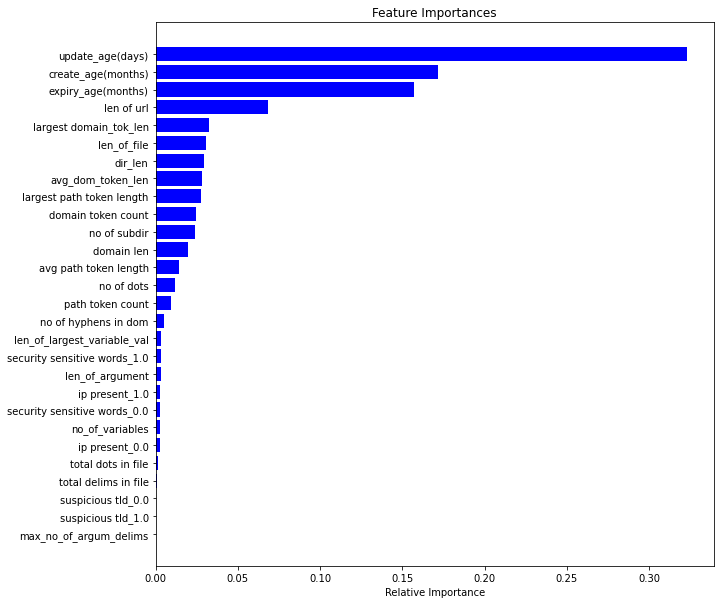

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(X, Y)

features=X.columns
importances=model.feature_importances_
indices = np.argsort(importances)
plt.rcParams["figure.figsize"] = (10,10)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Correlation Matrix

We plot the correlation matrix for our dataset

In [13]:
#Correlation Matrix

tempcombined.corr()

,len of url,no of dots,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,largest domain_tok_len,avg_dom_token_len,largest path token length,avg path token length,len_of_file,total dots in file,total delims in file,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),security sensitive words_0.0,security sensitive words_1.0,ip present_0.0,ip present_1.0,suspicious tld_0.0,suspicious tld_1.0,Label
len of url,1.000000,0.362412,0.158795,0.532186,0.485039,0.200613,0.068999,0.485039,0.125966,0.177198,0.458726,0.411394,0.382878,0.295427,0.233543,0.844546,0.613647,0.699188,0.640369,1.666090e-03,-3.881300e-04,-1.010281e-03,-0.288364,0.288364,4.357366e-03,-4.357366e-03,9.027888e-03,-9.027888e-03,3.199779e-01
no of dots,0.362412,1.000000,0.077061,0.281930,0.244603,0.277523,0.525099,0.244603,0.005397,-0.080403,0.226433,0.232993,0.134860,0.437459,0.082838,0.224089,0.285142,0.134571,0.148596,1.845497e-02,-6.050493e-06,-1.238127e-03,-0.242795,0.242795,-1.016166e-01,1.016166e-01,-5.826083e-03,5.826083e-03,9.429389e-02
no of hyphens in dom,0.158795,0.077061,1.000000,0.022055,-0.027226,0.478389,0.173040,-0.027226,0.398465,0.381272,0.057047,0.088294,0.105407,-0.006853,0.063943,0.080420,0.071685,0.040154,0.023841,-1.353814e-02,-1.447734e-02,-1.635309e-03,-0.133922,0.133922,3.423604e-02,-3.423604e-02,5.728064e-03,-5.728064e-03,1.533716e-01
dir_len,0.532186,0.281930,0.022055,1.000000,0.801791,0.012691,-0.060707,0.801791,0.025457,0.069823,0.869844,0.725486,0.169782,0.140294,0.178605,0.128728,0.199133,0.045753,0.077518,1.180151e-02,4.162624e-03,-1.048905e-03,-0.269548,0.269548,6.774862e-03,-6.774862e-03,1.991565e-02,-1.991565e-02,3.177932e-01
no of subdir,0.485039,0.244603,-0.027226,0.801791,1.000000,-0.044725,-0.149755,1.000000,0.016918,0.081820,0.525254,0.429060,0.131513,0.215632,0.107347,0.185822,0.266277,0.079613,0.114070,2.003771e-02,1.009773e-02,-1.680788e-03,-0.330000,0.330000,3.150683e-03,-3.150683e-03,3.491506e-02,-3.491506e-02,3.768954e-01
domain len,0.200613,0.277523,0.478389,0.012691,-0.044725,1.000000,0.523944,-0.044725,0.811465,0.718831,0.035023,0.044419,0.058093,-0.013227,0.047660,0.081163,0.069431,0.051569,0.076216,-4.552205e-02,-2.955315e-02,-2.434991e-03,-0.095958,0.095958,7.548038e-02,-7.548038e-02,-4.811929e-03,4.811929e-03,1.067550e-01
domain token count,0.068999,0.525099,0.173040,-0.060707,-0.149755,0.523944,1.000000,-0.149755,0.028748,-0.166501,0.004680,0.015270,0.058468,-0.061455,0.015133,0.019720,-0.027918,0.044595,0.059605,1.332795e-02,-2.299677e-03,-2.047154e-04,-0.051180,0.051180,-1.350307e-01,1.350307e-01,-4.248735e-02,4.248735e-02,-1.606889e-01
path token count,0.485039,0.244603,-0.027226,0.801791,1.000000,-0.044725,-0.149755,1.000000,0.016918,0.081820,0.525254,0.429060,0.131513,0.215632,0.107347,0.185822,0.266277,0.079613,0.114070,2.003771e-02,1.009773e-02,-1.680788e-03,-0.330000,0.330000,3.150683e-03,-3.150683e-03,3.491506e-02,-3.491506e-02,3.768954e-01
largest domain_tok_len,0.125966,0.005397,0.398465,0.025457,0.016918,0.811465,0.028748,0.016918,1.000000,0.917850,-0.000752,0.018261,-0.005116,0.008585,0.031569,0.030378,0.049390,-0.001494,0.007109,-8.603291e-02,-4.158343e-02,-3.266088e-03,-0.057961,0.057961,1.305791e-01,-1.305791e-01,2.963787e-02,-2.963787e-02,1.153895e-01
avg_dom_token_len,0.177198,-0.080403,0.381272,0.069823,0.081820,0.718831,-0.166501,0.081820,0.917850,1.000000,0.039709,0.052100,0.020706,0.050713,0.041839,0.078571,0.102000,0.026420,0.040712,-6.660674e-02,-3.267709e-02,-3.035833e-03,-0.076002,0.076002,1.386828e-01,-1.386828e-01,2.135630e-02,-2.135630e-02,2.298959e-01


# First Approach: AutoML TPOT 

We build a TPOTClassifier that automatically selects the best pipeline and exports it to a.py.

The TPOTClassifier cell takes a lot of time to execute, and I have copied the contents of the 'a.py' file into the next cell.

In [ ]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5,verbosity=3)
tpot.fit(X_train, y_train)
tpot.export('a.py')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic regression classifier on training set: 0.80
Accuracy of Logistic regression classifier on test set: 0.80
Accuracy of Decision Tree classifier on training set: 0.99
Accuracy of Decision Tree classifier on test set: 0.96
Accuracy of K-NN classifier on training set: 0.98
Accuracy of K-NN classifier on test set: 0.97
Accuracy of LDA classifier on training set: 0.88
Accuracy of LDA classifier on test set: 0.87
Accuracy of GNB classifier on training set: 0.83
Accuracy of GNB classifier on test set: 0.82
Accuracy of SVM classifier on training set: 0.91
Accuracy of SVM classifier on test set: 0.90
32 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['len of url', 'no of dots', 'security sensitive words', 'no of hyphens in dom', 'dir_len', 'no of subdir', 'domain len', 'domain token count', 'path token count', 'ip present', 'largest domain_tok_len', 'avg_dom_token_len', 'largest path token length', 'avg path token length', 'suspicious tld', 'len_of_file', 'total dots in file', 'total delims in file', 'len_of_argument', 'no_of_variables', 'len_of_largest_variable_val', 'max_no_of_argum_delims', 'create_age(months)', 'expiry_age(months)', 'update_age(days)'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']
expected total delims in file, total dots in file, max_no_of_argum_delims, ip present, len of 

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=5,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=3, warm_start=False)

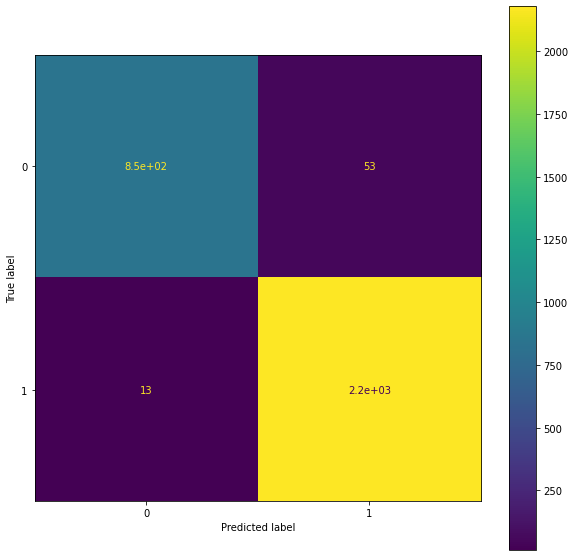



0.9767441860465116


              precision    recall  f1-score   support

           0       0.98      0.94      0.96       851
           1       0.98      0.99      0.98      2245

    accuracy                           0.98      3096
   macro avg       0.98      0.96      0.97      3096
weighted avg       0.98      0.98      0.98      3096

All scores: (0.9767441860465116, 0.9767441860465116, 0.9767441860465116, None)


In [23]:
#Data copied from the TPOT library framework

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

tpot_data = pd.read_csv('Final_Dataset.csv')
tpot_data.drop(['Unnamed: 0'], axis=1, inplace=True)
features = tpot_data.drop('Label', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['Label'], random_state=None)

# Average CV score on the training set was: 0.9760904684975769
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=0.01, fit_prior=True)),
    ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.8500000000000001, min_samples_leaf=4, min_samples_split=8, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
predict_test=exported_pipeline.predict(testing_features)
plot_confusion_matrix(exported_pipeline, X_test, y_test)
plt.show()
print("\n")
print(exported_pipeline.score(testing_features, testing_target))
print("\n")
print(classification_report(testing_target,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(testing_target, predict_test, average='micro')))

# Imports

In [24]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import precision_recall_fscore_support
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from math import sqrt
from sklearn.metrics import r2_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Reading

We read the final dataset one more time.

In [17]:
df = pd.read_csv('Final_Dataset.csv')
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [25]:
target_column = ['Label'] 
predictors = list(set(list(df.columns))-set(target_column))
#df[predictors] = df[predictors]/df[predictors].max()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
len of url,12381.0,0.041260,0.056323,0.0,0.011662,0.021137,0.047376,1.0
no of dots,12381.0,0.065111,0.060494,0.0,0.047619,0.047619,0.095238,1.0
no of hyphens in dom,12381.0,0.016385,0.043835,0.0,0.000000,0.000000,0.000000,1.0
dir_len,12381.0,0.030604,0.048852,0.0,0.001667,0.010000,0.043333,1.0
no of subdir,12381.0,0.068590,0.091922,0.0,0.000000,0.043478,0.130435,1.0
domain len,12381.0,0.093781,0.051798,0.0,0.062857,0.085714,0.114286,1.0
domain token count,12381.0,0.143470,0.059217,0.0,0.076923,0.153846,0.153846,1.0
path token count,12381.0,0.068590,0.091922,0.0,0.000000,0.043478,0.130435,1.0
largest domain_tok_len,12381.0,0.110217,0.069573,0.0,0.068182,0.102273,0.147727,1.0
avg_dom_token_len,12381.0,0.093479,0.049797,0.0,0.058104,0.087156,0.119266,1.0


In [26]:
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(8666, 28)
(3715, 28)


# Model building, evaluation and visualization

We build the following models:


1.   Multilayer Perceptron
2.   Logistic Regression
3. KNN
4. Gaussian NB
5. SVC




For Multilayer Perceptron:


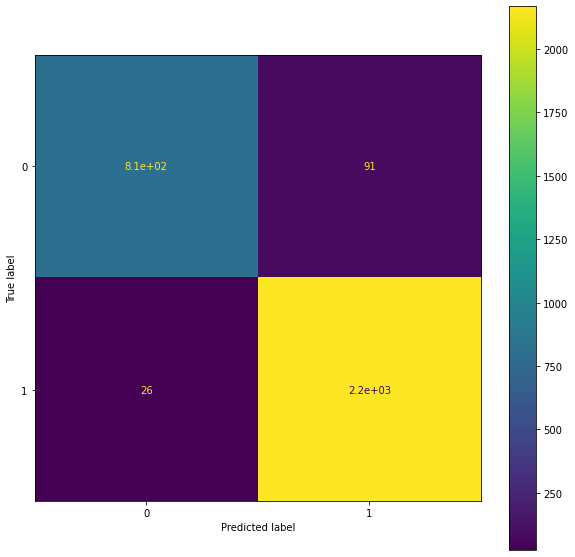

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       903
           1       0.96      0.99      0.97      2193

    accuracy                           0.96      3096
   macro avg       0.96      0.94      0.95      3096
weighted avg       0.96      0.96      0.96      3096

0.011855905152758778
All scores: (0.9622093023255814, 0.9622093023255814, 0.9622093023255814, None)
0.9436844505243959
The AUC Value is 0.9436844505243959


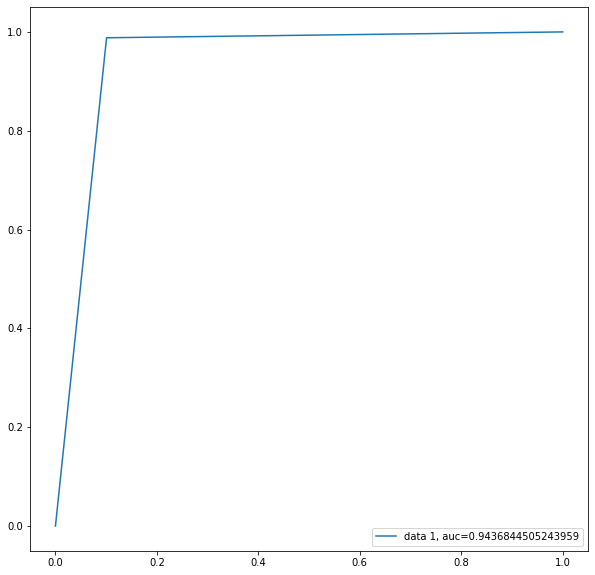




For Logistic Regression
0.09621523027815777


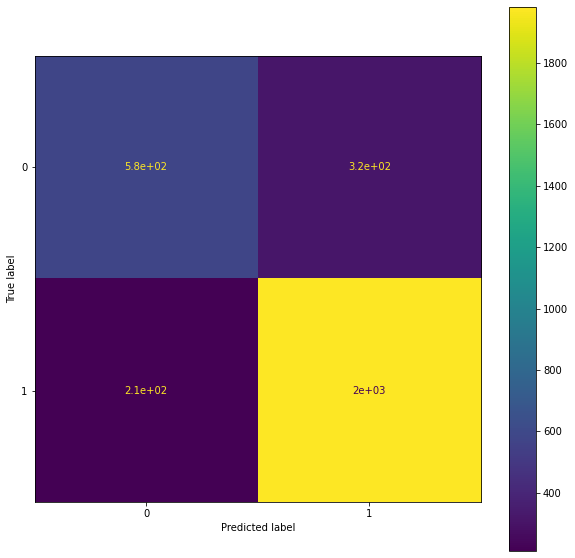

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       903
           1       0.86      0.90      0.88      2193

    accuracy                           0.83      3096
   macro avg       0.80      0.78      0.78      3096
weighted avg       0.82      0.83      0.83      3096

All scores: (0.8288113695090439, 0.8288113695090439, 0.8288113695090439, None)
[1 0 0 ... 0 1 1]
[1 0 0 ... 0 1 1]
The AUC Value is 0.7752589407856165


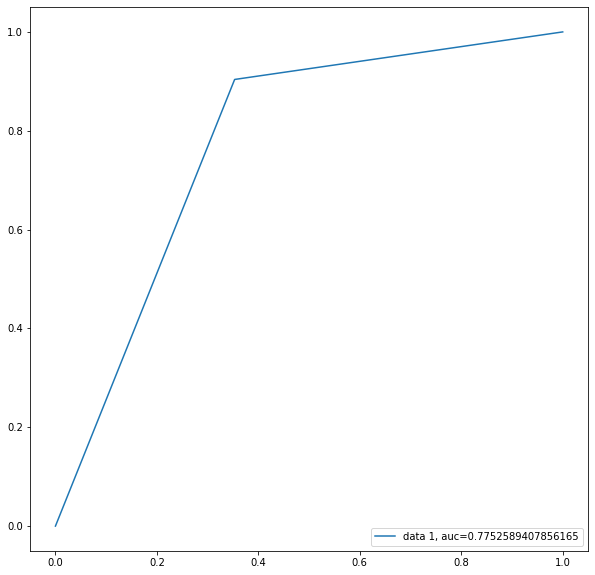




[[ 584  319]
 [ 211 1982]]
For Decision Tree Classifier
[[ 847   56]
 [  60 2133]]


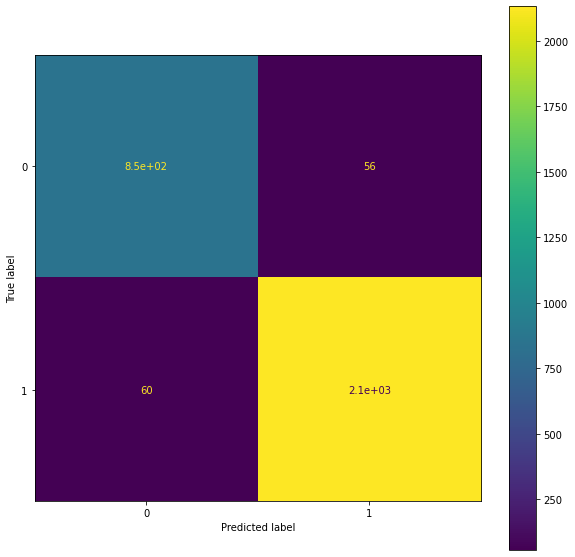

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       903
           1       0.97      0.97      0.97      2193

    accuracy                           0.96      3096
   macro avg       0.95      0.96      0.95      3096
weighted avg       0.96      0.96      0.96      3096

All scores: (0.962532299741602, 0.962532299741602, 0.962532299741602, None)
0.027359781121751026
The AUC Value is 0.95531235750114


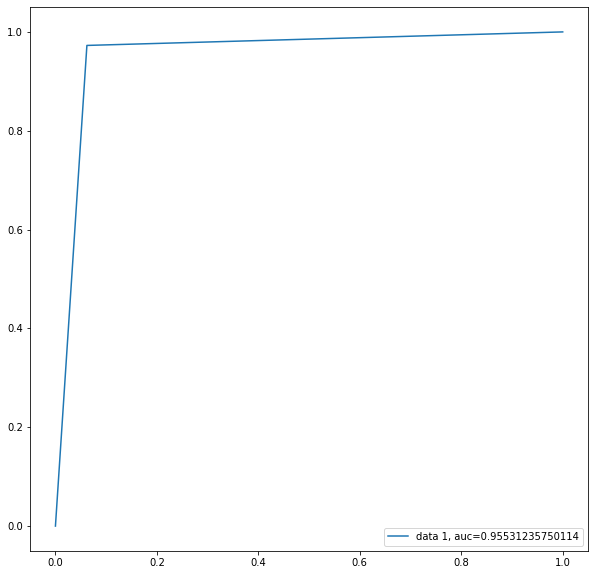




For K-Nearest Neighbours
0.01459188326493388


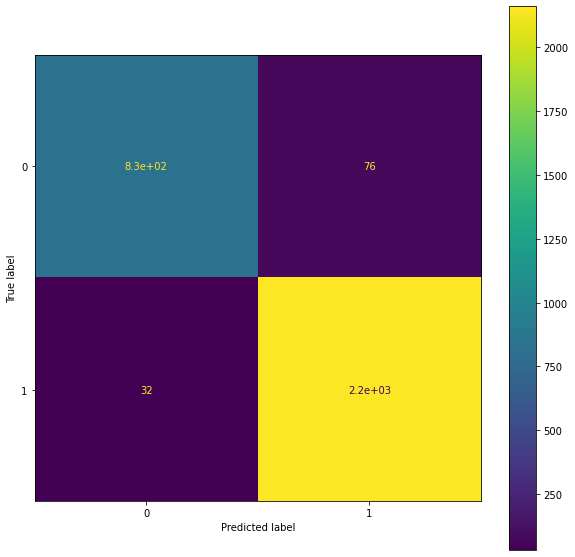

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       903
           1       0.97      0.99      0.98      2193

    accuracy                           0.97      3096
   macro avg       0.96      0.95      0.96      3096
weighted avg       0.97      0.97      0.96      3096

All scores: (0.9651162790697675, 0.9651162790697675, 0.9651162790697675, None)
The AUC Value is 0.9506221093088398


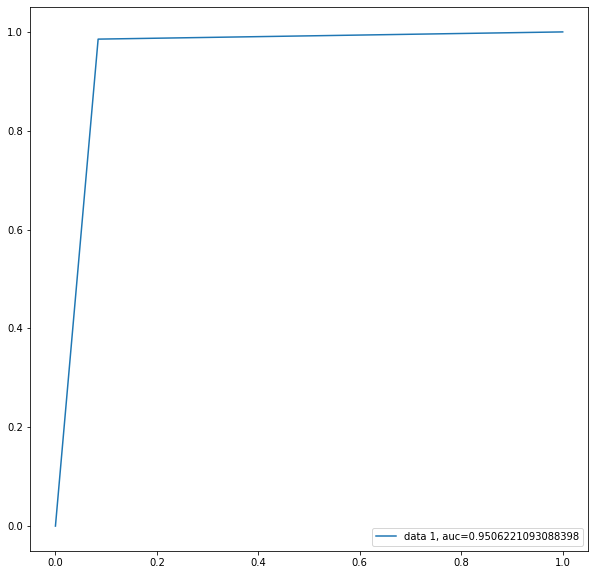




For Naive Bayes
0.38668490652074783


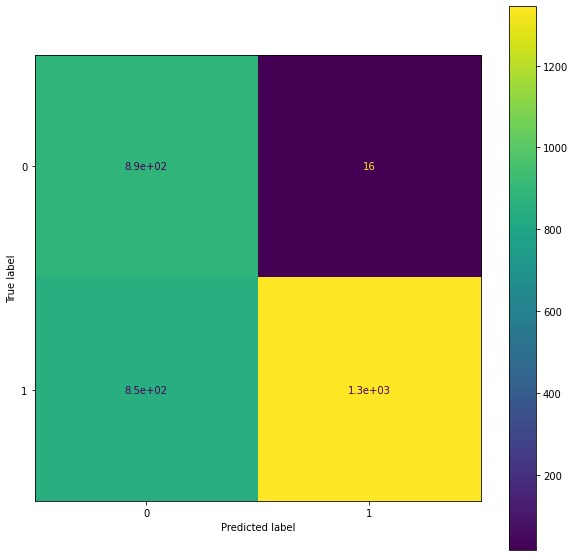

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       903
           1       0.99      0.61      0.76      2193

    accuracy                           0.72      3096
   macro avg       0.75      0.80      0.71      3096
weighted avg       0.85      0.72      0.73      3096

All scores: (0.7209302325581395, 0.7209302325581395, 0.7209302325581395, None)
The AUC Value is 0.7977981890430591


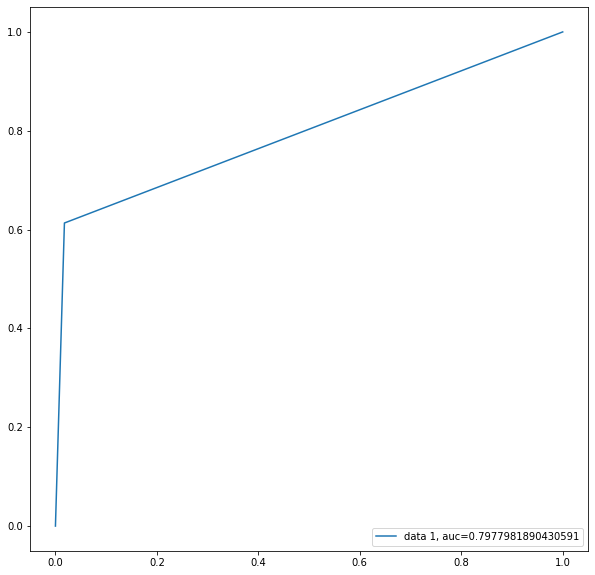




For Support Vector Machines:
0.05198358413132695


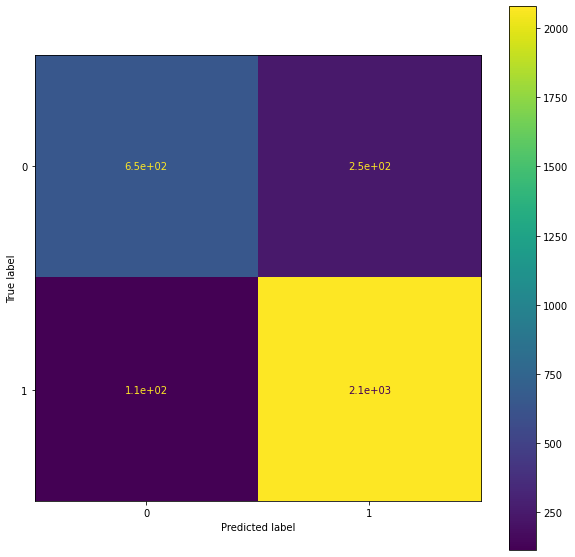

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       903
           1       0.89      0.95      0.92      2193

    accuracy                           0.88      3096
   macro avg       0.87      0.83      0.85      3096
weighted avg       0.88      0.88      0.88      3096

All scores: (0.8817829457364341, 0.8817829457364341, 0.8817829457364341, None)
The AUC Value is 0.8344733242134063


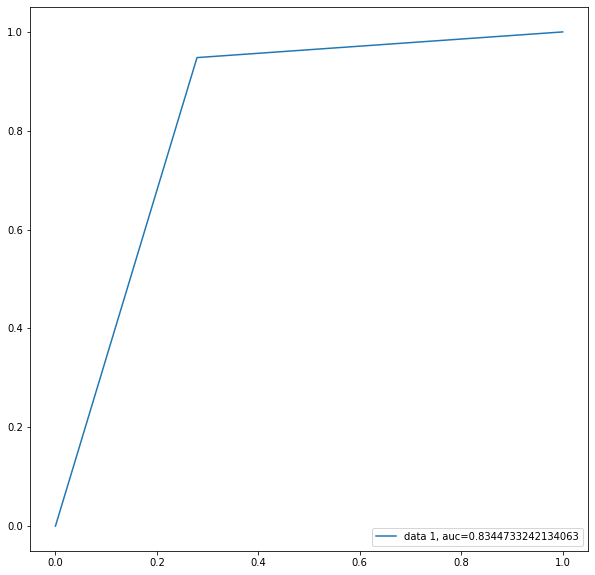




For Linear Support Vector Machines:
0.09575923392612859


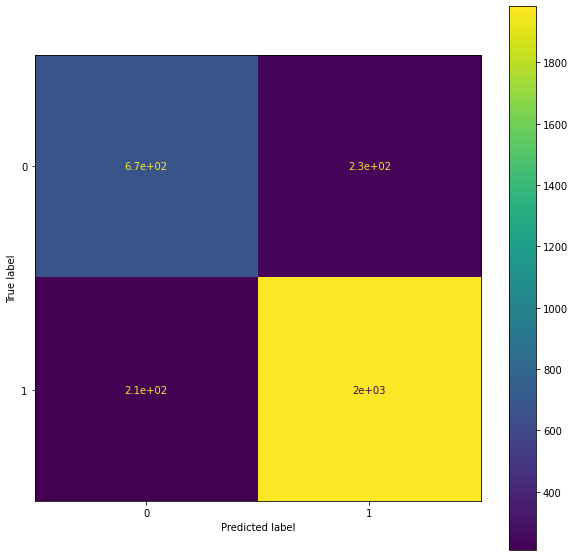

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       903
           1       0.89      0.90      0.90      2193

    accuracy                           0.86      3096
   macro avg       0.83      0.82      0.83      3096
weighted avg       0.86      0.86      0.86      3096






In [19]:
from sklearn.metrics import *
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print("For Multilayer Perceptron:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train.ravel())
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)
plot_confusion_matrix(mlp,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))
print(roc_auc_score(y_test, predict_test, average=None))

y_pred_proba = mlp.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")


y_train=y_train.ravel()
y_test=y_test.ravel()
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predict_train = logreg.predict(X_train)
predict_test = logreg.predict(X_test)
print("For Logistic Regression")
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)
plot_confusion_matrix(logreg,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))

y_pred_proba = logreg.predict_proba(X_test)[::,1]

print((y_test))
print((predict_test))

fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")

print(confusion_matrix(y_test,predict_test))


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
print("For Decision Tree Classifier")
print(confusion_matrix(y_test,predict_test))
plot_confusion_matrix(clf,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predict_train = knn.predict(X_train)
predict_test = knn.predict(X_test)
print("For K-Nearest Neighbours")
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)

plot_confusion_matrix(knn,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predict_train = gnb.predict(X_train)
predict_test = gnb.predict(X_test)
print("For Naive Bayes")
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)

plot_confusion_matrix(gnb,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))
y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")

from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
predict_train = svm.predict(X_train)
predict_test = svm.predict(X_test)
print("For Support Vector Machines:")
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)

plot_confusion_matrix(svm,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("All scores: "+ str(precision_recall_fscore_support(y_test, predict_test, average='micro')))

fpr, tpr, _ = roc_curve(y_test,  predict_test)
auc = roc_auc_score(y_test, predict_test)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
print("The AUC Value is", auc)
plt.legend(loc=4)
plt.show()
print("\n\n")


from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)
predict_train = svm.predict(X_train)
predict_test = svm.predict(X_test)
print("For Linear Support Vector Machines:")
tn, fp, fn, tp = confusion_matrix(y_test, predict_test).ravel()
false_negative_rate = fn / (tp + fn)
print(false_negative_rate)

plot_confusion_matrix(svm,X_test,y_test)
plt.show()
print(classification_report(y_test,predict_test))
print("\n\n")

# Result Tabularization

We tabularize the results..

In [22]:

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate



# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Import required libraries for machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Instantiate the machine learning classifiers
log_model = LogisticRegression()
svc_model = SVC()
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
knnmodel=KNeighborsClassifier()
#lda=LinearDiscriminantAnalysis()
tpot = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=0.01, fit_prior=True)),
    ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.8500000000000001, min_samples_leaf=4, min_samples_split=8, n_estimators=100)
)

# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y.ravel(), cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y.ravel(), cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y.ravel(), cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y.ravel(), cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y.ravel(), cv=folds, scoring=scoring)
    mlpb = cross_validate(mlp, X, y.ravel(), cv=folds, scoring=scoring)
    knn = cross_validate(knnmodel, X, y.ravel(), cv=folds, scoring=scoring)
    #ldam= cross_validate(lda, X, y.ravel(), cv=folds, scoring=scoring)
    tpotm= cross_validate(tpot, X, y.ravel(), cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()],
                                        
                                        'Multilayer Perceptron':[mlpb['test_accuracy'].mean(),
                                                              mlpb['test_precision'].mean(),
                                                              mlpb['test_recall'].mean(),
                                                              mlpb['test_f1_score'].mean()],
                                        'K-Nearest Neighbours':[knn['test_accuracy'].mean(),
                                                              knn['test_precision'].mean(),
                                                              knn['test_recall'].mean(),
                                                              knn['test_f1_score'].mean()],
                                        # 'Linear Discriminant Analysis':[ldam['test_accuracy'].mean(),
                                        #                       ldam['test_precision'].mean(),
                                        #                       ldam['test_recall'].mean(),
                                        #                       ldam['test_f1_score'].mean()],
                                        'TPOT Model':[tpotm['test_accuracy'].mean(),
                                                              tpotm['test_precision'].mean(),
                                                              tpotm['test_recall'].mean(),
                                                              tpotm['test_f1_score'].mean()]


                                        },
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table).transpose()
  
# Run models_evaluation function
models_evaluation(X,Y, 5)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.825054,0.873661,0.887362,0.879287
Support Vector Classifier,0.884014,0.901353,0.942838,0.921249
Decision Tree,0.960019,0.976023,0.968492,0.972125
Random Forest,0.969469,0.973684,0.984584,0.978977
Gaussian Naive Bayes,0.721263,0.98965,0.618533,0.758509
Multilayer Perceptron,0.961311,0.9657,0.981322,0.973364
K-Nearest Neighbours,0.955092,0.958666,0.980532,0.969247
TPOT Model,0.971569,0.971863,0.989536,0.980495
Best Score,TPOT Model,Gaussian Naive Bayes,TPOT Model,TPOT Model
